# Import Required Libraries

In [1]:
import sys
import os

os.chdir("..")
os.chdir("..")
os.chdir("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from ICA import *
from dsp_utils import *
from general_utils import *
from visualization_utils import *

import warnings

warnings.filterwarnings("ignore")

notebook_name = "ICA_InfoMax"

# Source Generation and Mixing Scenario

In [3]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10
S = generate_correlated_copula_sources(
    rho=0.0,
    df=4,
    n_sources=NumberofSources,
    size_sources=N,
    decreasing_correlation=True,
)

S = 2 * S - 1
print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures, NumberofSources)
X = np.dot(A, S)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise=True)

SNRinp = 10 * np.log10(
    np.sum(np.mean((X - NoisePart) ** 2, axis=1))
    / np.sum(np.mean(NoisePart**2, axis=1))
)
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.998447015810243


# Visualize Generated Sources and Mixtures

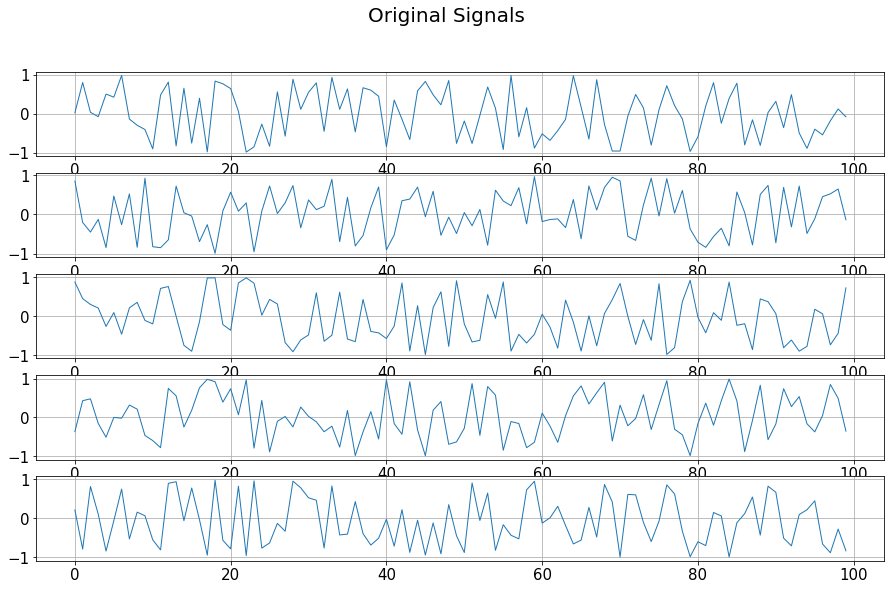

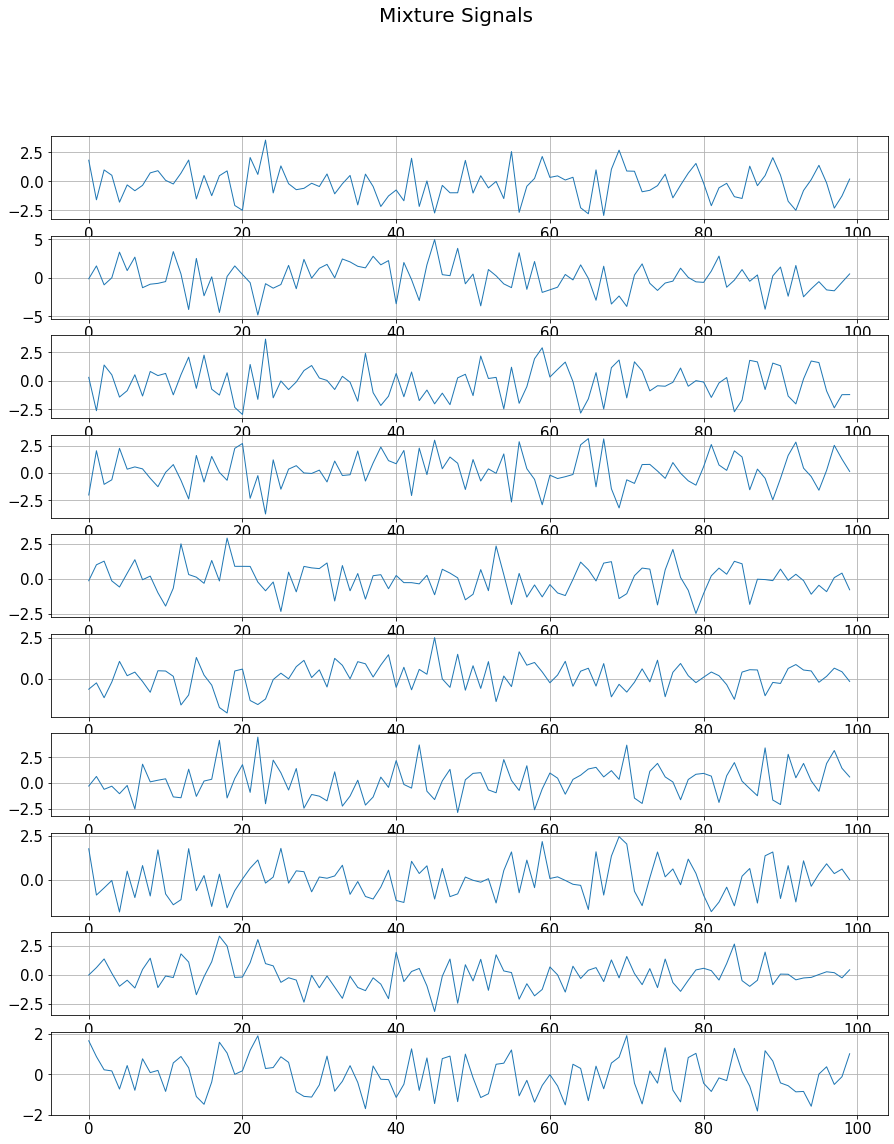

In [4]:
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)
subplot_1D_signals(
    X[:, 0:100], title="Mixture Signals", figsize=(15, 18), colorcode=None
)

# Run ICA-InfoMax Algorithm on Mixture Signals

In [5]:
with Timer() as t:
    Y = fit_icainfomax(X, NumberofSources)
print("Algorithm took %f sec." % (t.interval))

Creating RawArray with float64 data, n_channels=10, n_times=500000
    Range : 0 ... 499999 =      0.000 ...   250.000 secs
Ready.
Algorithm took 46.541965 sec.


# Calculate Resulting Component SNRs and Overall SINR

In [6]:
Y_ = signed_and_permutation_corrected_sources(S, Y)
coef_ = ((Y_ * S).sum(axis=1) / (Y_ * Y_).sum(axis=1)).reshape(-1, 1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr(S, Y_)))

SINRwsm = 10 * np.log10(CalculateSINR(Y_, S)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [31.64636804 29.14201562 30.39509713 31.35429556 30.11026647]

Overall SINR : 30.43546452110349


In [7]:
WfICA = Y @ np.linalg.pinv(X)
CalculateSIR(A, WfICA)

(54.63361777856696, 5)

# Vizualize Extracted Signals Compared to Original Sources

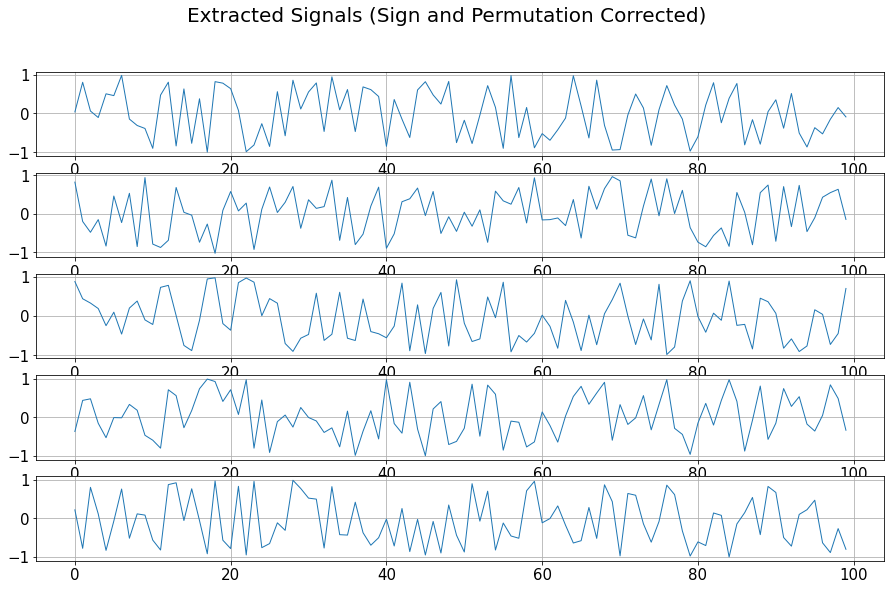

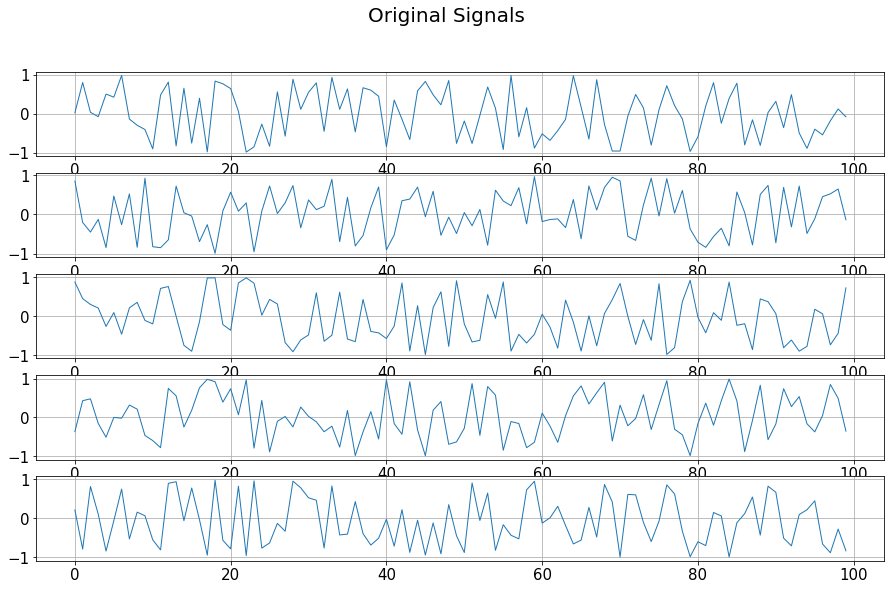

In [8]:
subplot_1D_signals(
    Y_[:, 0:100],
    title="Extracted Signals (Sign and Permutation Corrected)",
    figsize=(15.2, 9),
    colorcode=None,
)
subplot_1D_signals(
    S[:, 0:100], title="Original Signals", figsize=(15.2, 9), colorcode=None
)